In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import re

csv_files = glob('../*.csv')

In [2]:
def zone_pass(element):
    pattern = re.compile(r'\[(\d), (\d), \d, \d, \d')
    matches = pattern.search(element)
    test = int(matches.group(1))#+int(matches.group(2))
    if test>=1: #==2:
        return 1
    return 0

In [3]:
def mean(element):
    pattern = re.compile(r'\[(\d+.\d+), (\d+.\d+)\]')
    matches = pattern.search(element)
    try:
        return float(matches.group(1))+float(matches.group(2))/2
    except:
        return "something wrong!"

In [4]:
csv_files.remove('../result.csv')
csv_files.remove('../result1.csv')
csv_files.remove('../result-nature.csv')
csv_files.remove('../result-nature-v2.csv')

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
def score_pred(data, thrd=0.2):
    return np.array([1 if item<thrd  else 0 for item in data])

In [7]:
def fpr_tpr(y_true, y_pred):
    
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    rm = np.sum(y_pred == 0)/len(y_pred)
    
    return fp/(fp+tn), tp/(tp+fn), rm

### Can jump to pipe

In [8]:
df_map = {}
for item in csv_files:
    df_map[item] = pd.read_csv(item,index_col=0)
#df_map[csv_files[0]].head()

In [9]:
df_1 = df_map[csv_files[0]]

In [10]:
df_1['test_zone'].apply(zone_pass)

4    1
5    1
6    1
7    0
8    1
9    1
Name: test_zone, dtype: int64

In [11]:
df_1['BG_real'].apply(mean)

4    282.0
5    258.0
6    273.5
7    212.5
8    226.0
9    218.0
Name: BG_real, dtype: float64

In [12]:
df_1['BG_pred'].apply(mean)

4    334.397550
5    278.780515
6    261.697955
7    348.299650
8    268.897965
9    243.994905
Name: BG_pred, dtype: float64

In [13]:
zone_pass_list = []
score_1_list = []
score_2_list = []

for item in csv_files:
    zone_pass_list += df_map[item]['test_zone'].apply(zone_pass).tolist()
    score_1_list += df_map[item]['score_1'].tolist()
    score_2_list += df_map[item]['score_2'].tolist()

In [14]:
zone_pass_arr = np.array(zone_pass_list)
score_1_arr = np.array(score_1_list)
score_2_arr = np.array(score_2_list)

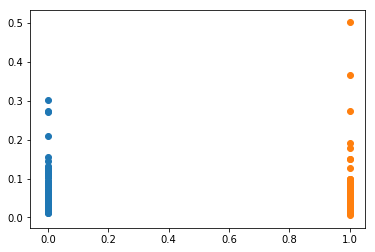

In [15]:
for i in range(2):
    plt.scatter(zone_pass_arr[zone_pass_arr==i], score_1_arr[zone_pass_arr==i])

In [16]:
y = zone_pass_arr

In [17]:
def roc_df(data, model, thr_start, thr_end, points, plot=False, ret=False):
    fpr, tpr, thr, rmr = [], [], [], []
    for thrd in np.linspace(thr_start, thr_end, points):
        ypred = score_pred(data, thrd)
        f, t, rm = fpr_tpr(y, ypred)
        fpr.append(f)
        tpr.append(t)
        rmr.append(rm)
        thr.append(thrd)
    if plot:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_title('DL Receiver Operating Curve',fontsize=15)
        p1, = ax.plot(fpr, tpr, c='b',zorder=40, label='TPR')
        ax.plot([0, 1], [0, 1], 'k--', lw=2,zorder=40)
        ax.set_xlabel('False Positive Rate',fontsize=13.5)
        ax.set_ylabel('True Positive Rate(TPR)',fontsize=13.5)
        ax.yaxis.label.set_color(p1.get_color())
        ax.hlines(0.716,0,0.45,colors='b',linestyles='dashed')
        ax.vlines(0.451,0,0.716,colors='r',linestyles='dashed')
        ax.hlines(0.355,0.45,1,colors='g',linestyles='dashed')
        plt.scatter([0.451,0.451], [0.716,0.355],c='red',s=50,zorder=60, alpha=0.8)
        label_x, label_y = 0.05, 0.85
        arrow_x, arrow_y = 0.451613, 0.716312
        arrow_properties = dict(facecolor="black", width=0.5,
                                headwidth=4, shrink=0.2)

        ax.annotate("Threshold: 0.06", xy=(arrow_x, arrow_y),
                     xytext=(label_x, label_y),
                     arrowprops=arrow_properties)        
        ax2 = ax.twinx()
        p2, = ax2.plot(fpr, rmr, c='g', label='Reject ratio')
        ax2.set_ylabel('Reject ratio',fontsize=13.5)
        ax2.yaxis.label.set_color(p2.get_color())
        ax.tick_params(axis='y', colors=p1.get_color())
        ax2.tick_params(axis='y', colors=p2.get_color())
        #plt.legend()
        lines = [p1, p2]
        ax.legend(lines, [l.get_label() for l in lines],loc='right')
        plt.tight_layout()
        plt.show()
    if ret:
        return pd.DataFrame({'thrd':thr, 'fpr':fpr, 'tpr':tpr, 'rmr':rmr})

In [18]:
plt.rcParams.update({'font.size': 12.5})

In [19]:
df_roc = roc_df(score_2_arr, score_pred, 0, 0.3, 601, plot=False, ret=True)
df_roc[(df_roc['tpr']>0.6) & (df_roc['fpr']<0.5)]

,thrd,fpr,tpr,rmr
101,0.0505,0.370968,0.602837,0.467980
102,0.0510,0.370968,0.609929,0.463054
103,0.0515,0.370968,0.609929,0.463054
104,0.0520,0.370968,0.617021,0.458128
105,0.0525,0.370968,0.617021,0.458128
106,0.0530,0.370968,0.645390,0.438424
107,0.0535,0.370968,0.645390,0.438424
108,0.0540,0.370968,0.652482,0.433498
109,0.0545,0.370968,0.659574,0.428571
110,0.0550,0.403226,0.666667,0.413793


In [20]:
def roc2_df(data, y, thr_start, thr_end, points, plot=False, ret=False):
    fpr, tpr, thr, rmr = [], [], [], []
    for thrd in np.linspace(thr_start, thr_end, points):
        ypred = score_pred(data, thrd)
        f, t, rm = fpr_tpr(y, ypred)
        fpr.append(f)
        tpr.append(t)
        rmr.append(rm)
        thr.append(thrd)
    if plot:
        fig, ax = plt.subplots(constrained_layout=True)
        plt.title('DL Receiver Operating Curve',fontsize=15)
        p1, = ax.plot(fpr, tpr, zorder=40, label='TPR') # c='b',
        plt.plot([0, 1], [0, 1], 'k--', lw=2,zorder=40)
        ax.set_xlabel('False Positive Rate',fontsize=13.5)
        ax.set_ylabel('True Positive Rate(TPR)',fontsize=13.5)
        
        line = [p1]
        ax.legend(line, [l.get_label() for l in line],loc='lower right')
        #plt.savefig('ROC curve-1.png',dpi=400)
        plt.show()
    if ret:
        return pd.DataFrame({'thrd':thr, 'fpr':fpr, 'tpr':tpr, 'rmr':rmr})

In [21]:
def roc_pipe(start=4):
    df_map = {}
    for item in csv_files:
        df = pd.read_csv(item,index_col=0)
        if df.shape[0]>start-4:
            df_map[item] = df.loc[start:,:]
    
    zone_pass_list = []
    score_1_list = []
    score_2_list = []

    for item in df_map.keys(): #csv_files
        zone_pass_list += df_map[item]['test_zone'].apply(zone_pass).tolist()
        score_1_list += df_map[item]['score_1'].tolist()
        score_2_list += df_map[item]['score_2'].tolist()

    zone_pass_arr = np.array(zone_pass_list)
    score_1_arr = np.array(score_1_list)
    score_2_arr = np.array(score_2_list)
    
    y = zone_pass_arr
    
    return roc2_df(score_2_arr,y, 0, 0.5, 601, plot=True, ret=True)

Round from: 4


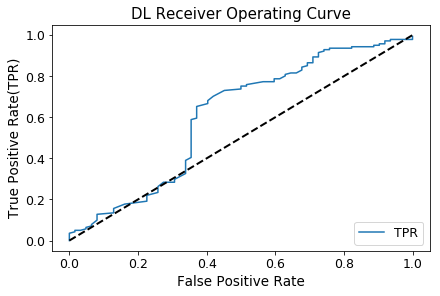

Round from: 5


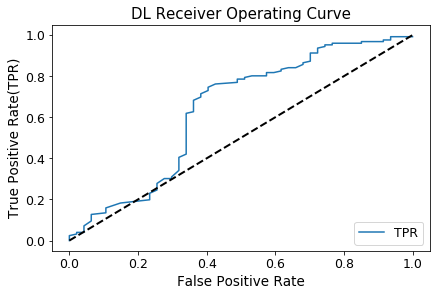

Round from: 6


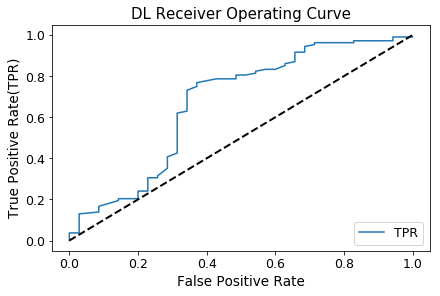

Round from: 7


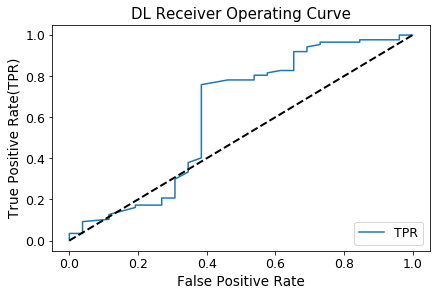

Round from: 8


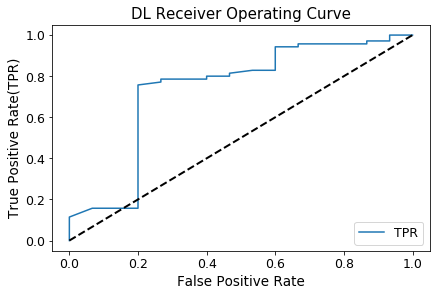

In [22]:
DL_results = []
for i in range(4,9):
    print("Round from: %d"%i)
    DL_results.append(roc_pipe(i))

In [23]:
r8_df = DL_results[-1]
r8_df[(r8_df['fpr']<0.35) & (r8_df['tpr']>0.6)]

,thrd,fpr,tpr,rmr
63,0.052500,0.200000,0.614286,0.458824
64,0.053333,0.200000,0.671429,0.411765
65,0.054167,0.200000,0.685714,0.400000
66,0.055000,0.200000,0.700000,0.388235
67,0.055833,0.200000,0.700000,0.388235
68,0.056667,0.200000,0.700000,0.388235
69,0.057500,0.200000,0.728571,0.364706
70,0.058333,0.200000,0.742857,0.352941
71,0.059167,0.200000,0.757143,0.341176
72,0.060000,0.266667,0.771429,0.317647


In [24]:
r8_df

,thrd,fpr,tpr,rmr
0,0.000000,0.0,0.000000,1.000000
1,0.000833,0.0,0.000000,1.000000
2,0.001667,0.0,0.000000,1.000000
3,0.002500,0.0,0.000000,1.000000
4,0.003333,0.0,0.000000,1.000000
5,0.004167,0.0,0.000000,1.000000
6,0.005000,0.0,0.000000,1.000000
7,0.005833,0.0,0.000000,1.000000
8,0.006667,0.0,0.000000,1.000000
9,0.007500,0.0,0.000000,1.000000


* The best ROC is found at round 8 as the starting point. 
* Comparison between IL and DL in ROC shows clearly that the DL model performs better.
* However, from threshold finding aspect it may not be appropriate by choosing the subset.
* The purpose is to optimize the future prediction from the accumulated data and the pretrained model.
* If the threshold is choosing from the prediction subset only, the 

### Combine IL and DL

In [25]:
IL_result = np.load('../../beta-1000-v7-no-pair-no-BG-last-ROC/roc_r8.npy')

/root/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/figure.py:2147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


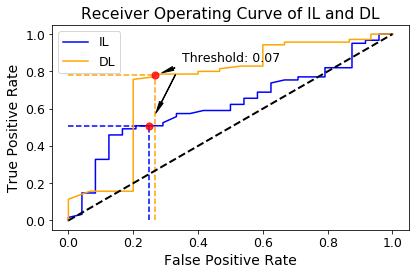

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Receiver Operating Curve of IL and DL',fontsize=15.5)
plt.plot([0, 1], [0, 1], 'k--', lw=2,zorder=40)
ax.set_xlabel('False Positive Rate',fontsize=14)
ax.set_ylabel('True Positive Rate',fontsize=14)
plt.plot(IL_result[:,1],IL_result[:,2],label='IL',c='blue')
plt.plot(DL_results[-1]['fpr'], DL_results[-1]['tpr'],label='DL',c='orange')

plt.scatter(0.266667, 0.782857, c='red',s=50,zorder=60, alpha=0.8)
plt.scatter(0.250000, 0.508197, c='red',s=50,zorder=60, alpha=0.8)


ax.hlines(0.78,0,0.266667,colors='orange',linestyles='dashed')
ax.vlines(0.266667,0,0.78,colors='orange',linestyles='dashed')

ax.hlines(0.508,0,0.25,colors='blue',linestyles='dashed')
ax.vlines(0.25,0,0.508,colors='blue',linestyles='dashed')

label_x, label_y = 0.35, 0.85
arrow_x1, arrow_y1 = 0.273, 0.782
arrow_x2, arrow_y2 = 0.25, 0.508

arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.2)
ax.annotate("Threshold: 0.07", xy=(arrow_x1, arrow_y1),xytext=(label_x, label_y),arrowprops=arrow_properties)
ax.annotate('',xy=(arrow_x2, arrow_y2),xytext=(label_x, label_y),arrowprops=arrow_properties)

plt.legend()
plt.tight_layout()
plt.show()


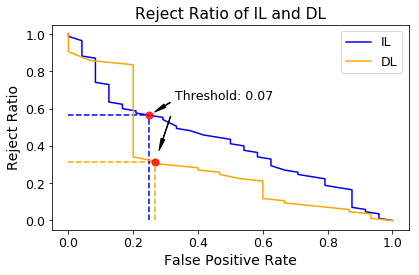

In [27]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Reject Ratio of IL and DL',fontsize=15.5)
#plt.plot([0, 1], [0, 1], 'k--', lw=2,zorder=40)
ax.set_xlabel('False Positive Rate',fontsize=14)
ax.set_ylabel('Reject Ratio',fontsize=14)
plt.plot(IL_result[:,1],IL_result[:,3],label='IL',c='blue')
plt.plot(DL_results[-1]['fpr'], DL_results[-1]['rmr'],label='DL',c='orange')

plt.scatter(0.266667, 0.311176, c='red',s=50,zorder=60, alpha=0.8)
plt.scatter(0.250000, 0.564706, c='red',s=50,zorder=60, alpha=0.8)


ax.hlines(0.3112,0,0.266667,colors='orange',linestyles='dashed')
ax.vlines(0.266667,0,0.3412,colors='orange',linestyles='dashed')

ax.hlines(0.565,0,0.25,colors='blue',linestyles='dashed')
ax.vlines(0.25,0,0.565,colors='blue',linestyles='dashed')



label_x, label_y = 0.33, 0.65
arrow_x1, arrow_y1 = 0.267, 0.3112
arrow_x2, arrow_y2 = 0.25, 0.565

arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.2)
ax.annotate("Threshold: 0.07", xy=(arrow_x1, arrow_y1),xytext=(label_x, label_y),arrowprops=arrow_properties)
ax.annotate('',xy=(arrow_x2, arrow_y2),xytext=(label_x, label_y),arrowprops=arrow_properties)


plt.legend()
plt.tight_layout()
plt.show()
